## Prepare augments

In [1]:
import os
import os.path as osp

import torch

from torch import nn
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

from sslh.transforms.containers import RandomChoice
from sslh.transforms.spectrogram.cutoutspec import CutOutSpec
from sslh.transforms.spectrogram.flips import HorizontalFlip, VerticalFlip
from sslh.transforms.spectrogram.spec_aug import SpecAugmentation
from sslh.transforms.waveform.resample_pad_crop import ResamplePadCrop
from sslh.transforms.waveform.occlusion import Occlusion

/homelocal/labbeti/miniconda3/envs/env_sslh/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homelocal/labbeti/miniconda3/envs/env_sslh/lib/python3.9/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
seed = 1234
# Optional transform to spectrogram
n_mels = 64
n_time = 500
sr = 32000
n_fft = 2048
hop_length = sr * 10 // n_time

img_dpath = './img'
os.makedirs(img_dpath, exist_ok=True)

torch.random.manual_seed(1234)
transform_to_spec = nn.Sequential(
    MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels),
    AmplitudeToDB(),
)

ResamplePadCrop only resample signal waveform of length L to length (L * rate) and pad/crop it to return a waveform of length L.
The rate is uniformly sampled from a pre-defined range "rates".

CutOutSpec remove some value in a spectrogram by replacing value in a random rectangle area by -80.0 dB.
The width and height of the rectangle will be defined by scales (height_spec * height_scale, width_spec * width_scale),
where spectrogram has shape (height_spec, width_spec) and scales are uniformly generated in pre-defined ranges "width_scales" and "height_scales".

Occlusion replace a interval of values in the waveform by 0.
The length of this interval is defined by the scale uniformly sampled from the range "scales".

## nn.Sequential for weak augment

In [3]:
p = 0.5
augm = RandomChoice(
    nn.Sequential(
        ResamplePadCrop(rates=(0.9, 1.1), p=p),
        transform_to_spec,
    ),
    nn.Sequential(
        transform_to_spec,
        CutOutSpec(freq_scales=(0.1, 0.5), time_scales=(0.1, 0.5), fill_value=-80.0, p=p),
    ),
    nn.Sequential(
        Occlusion(scales=(0.1, 0.3), fill_value=0.0, p=p),
        transform_to_spec,
    ),
)

In [4]:
print(augm)

RandomChoice(
  (0): Sequential(
    (0): ResamplePadCrop(
      (stretch): Resample(rates=(0.9, 1.1))
      (pad): Pad(target_length=1, align=random, fill_value=0.0, dim=-1, mode=constant)
      (crop): Crop(target_length=1, align=random, dim=-1)
    )
    (1): Sequential(
      (0): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (1): AmplitudeToDB()
    )
  )
  (1): Sequential(
    (0): Sequential(
      (0): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (1): AmplitudeToDB()
    )
    (1): CutOutSpec()
  )
  (2): Sequential(
    (0): Occlusion()
    (1): Sequential(
      (0): MelSpectrogram(
        (spectrogram): Spectrogram()
        (mel_scale): MelScale()
      )
      (1): AmplitudeToDB()
    )
  )
)


## Test

In [5]:
import math

import torch

from matplotlib import pyplot as plt
from torch import Tensor

In [6]:
def gen_note(freq_note: float, duration: float, sample_rate: int, amplitude: float = 1.0) -> Tensor:
    nb_samples = duration * sample_rate
    x = torch.arange(start=0, end=nb_samples)
    note = amplitude * torch.sin(freq_note * x * 2.0 * math.pi / sample_rate)
    return note

# 0.5 Hz, 10 s
waveform = gen_note(0.5, 10, sr)
# Spec shape (mel, time) : (64, 501)
spec = transform_to_spec(waveform)
p = 1.0
stretch = ResamplePadCrop(rates=(0.5, 0.5), p=p)
cutout_spec = CutOutSpec(freq_scales=(0.4, 0.4), time_scales=(0.4, 0.4), fill_value=-80.0, p=p)
occlusion = Occlusion(scales=(0.4, 0.5))

/homelocal/labbeti/miniconda3/envs/env_sslh/lib/python3.9/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/homelocal/labbeti/miniconda3/envs/env_sslh/lib/python3.9/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_le

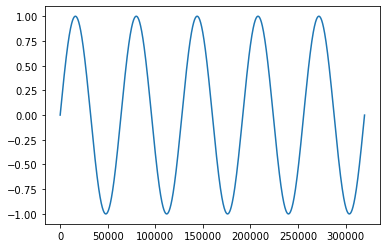

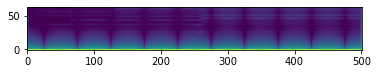

In [7]:
plt.plot(waveform)
plt.gca().set_axis_off()
plt.savefig(osp.join(img_dpath, 'example_waveform.png'))
plt.gca().set_axis_on()
plt.show()

plt.imshow(spec, origin="lower")
plt.gca().set_axis_off()
plt.savefig(osp.join(img_dpath, 'example_spectro.png'))
plt.gca().set_axis_on()
plt.show()

## ResamplePadCrop example:

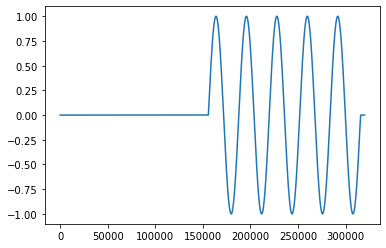

In [8]:
plt.plot(stretch(waveform))
plt.gca().set_axis_off()
plt.savefig(osp.join(img_dpath, 'example_waveform_time_stretch_pad_crop.png'))
plt.gca().set_axis_on()
plt.show()

## CutOutSpec example:

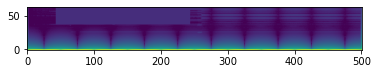

In [9]:
plt.imshow(cutout_spec(spec), origin="lower")
plt.gca().set_axis_off()
plt.savefig(osp.join(img_dpath, 'example_spectro_cutoutspec.png'))
plt.gca().set_axis_on()
plt.show()

## Occlusion example:

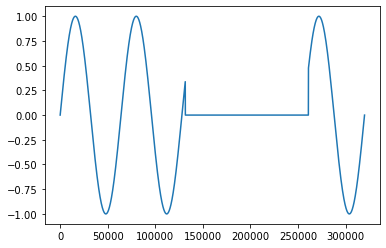

In [10]:
plt.plot(occlusion(waveform))
plt.savefig(osp.join(img_dpath, 'example_waveform_occlusion.png'))
plt.gca().set_axis_on()
plt.show()

## Augments composed example:

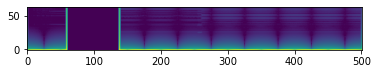

In [11]:
plt.imshow(augm(waveform), origin="lower")
plt.show()

## ResamplePadCrop on spec ?

In [12]:
stretch = ResamplePadCrop(rates=(0.5, 0.5), p=p)
waveform_stretch = stretch(waveform)
spec_stretch_1 = transform_to_spec(waveform_stretch)

stretch = ResamplePadCrop(rates=(0.5, 0.5), p=p, fill_value=-100.0)
spec_stretch_2 = stretch(spec)

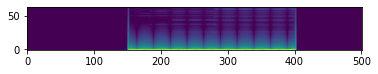

In [13]:
plt.imshow(spec_stretch_1, origin="lower")
plt.show()

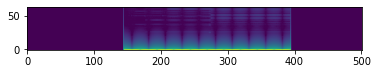

In [14]:
plt.imshow(spec_stretch_2, origin="lower")
plt.show()

## Occlusion on spec ?

In [15]:
occlusion = Occlusion(scales=(0.4, 0.4))
waveform_occlusion = occlusion(waveform)
spec_occlusion_1 = transform_to_spec(waveform_occlusion)

occlusion = Occlusion(scales=(0.4, 0.4), fill_value=-100.0)
spec_occlusion_2 = occlusion(spec)

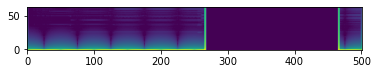

In [16]:
plt.imshow(spec_occlusion_1, origin="lower")
plt.show()

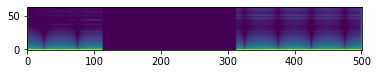

In [17]:
plt.imshow(spec_occlusion_2, origin="lower")
plt.show()


## Occlusion or CutOut ?

In [18]:
cutout_spec = CutOutSpec(freq_scales=(1.0, 1.0), time_scales=(0.4, 0.4), fill_value=-100.0)
spec_cutout_spec = cutout_spec(spec)

occlusion = Occlusion(scales=(0.4, 0.4), fill_value=-100.0)
spec_occlusion = occlusion(spec)

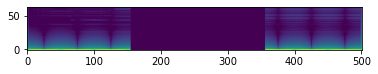

In [19]:
plt.imshow(spec_cutout_spec, origin="lower")
plt.show()

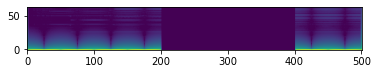

In [20]:
plt.imshow(spec_occlusion, origin="lower")
plt.show()

## Pitch Shift

In [21]:
from librosa.effects import pitch_shift

# print(spec.shape)
waveform_np = waveform.cpu().numpy()
waveform_ps = pitch_shift(waveform_np, sr, n_steps=4.0)
waveform_ps = torch.from_numpy(waveform_ps)

spec_ps = transform_to_spec(waveform_ps)

/tmp/ipykernel_1374924/3607483412.py:5: FutureWarning: Pass sr=32000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  waveform_ps = pitch_shift(waveform_np, sr, n_steps=4.0)


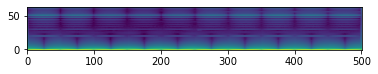

In [22]:
plt.imshow(spec_ps, origin="lower")
plt.show()

In [23]:
# from mlu.transforms.waveform.pitch_shift import PitchShift
# ps2 = PitchShift(sr, n_steps=4.0)
# waveform_ps2 = ps2(waveform)
# spec_ps2 = transform_to_spec(waveform_ps2)

In [24]:
# plt.imshow(spec_ps2, origin="lower")
# plt.show()


## CutOutSpec with other types of fill

In [25]:
cutout_spec = CutOutSpec(
	freq_scales=(0.5, 0.5),
	time_scales=(0.5, 0.5),
	fill_value=(-100, -80),
	fill_mode='random',
)

spec_cr = cutout_spec(spec)

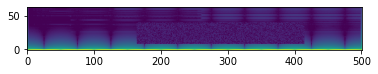

In [26]:
plt.imshow(spec_cr, origin="lower")
plt.show()


In [27]:
from sslh.transforms.other.fade import Fade
cutout_spec = CutOutSpec(
	freq_scales=(0.5, 0.5),
	time_scales=(0.5, 0.5),
	fill_mode=Fade(factor=0.5),
)

spec_cf = cutout_spec(spec)

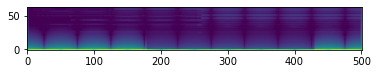

In [28]:
plt.imshow(spec_cf, origin="lower")
plt.show()

In [29]:
from sslh.transforms.other.noise import SubtractiveNoise
cutout_spec = CutOutSpec(
	freq_scales=(0.75, 0.75),
	time_scales=(0.75, 0.75),
	fill_mode=SubtractiveNoise(snr_db=15.0),
)

spec_cn = cutout_spec(spec)

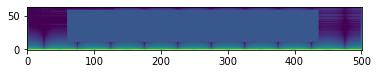

In [30]:
plt.imshow(spec_cn, origin="lower")
plt.show()

TimeStretch waveform or spec comparison

In [31]:
stretch = ResamplePadCrop(rates=(0.5, 0.5), p=p, align='left')
waveform_stretch = stretch(waveform)
spec_stretch_1 = transform_to_spec(waveform_stretch)

stretch = ResamplePadCrop(rates=(0.5, 0.5), p=p, fill_value=-100.0, align='left')
spec_stretch_2 = stretch(spec)

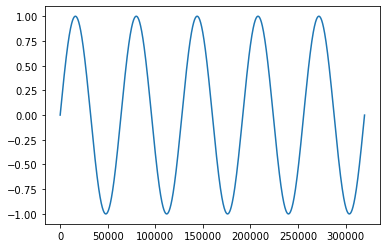

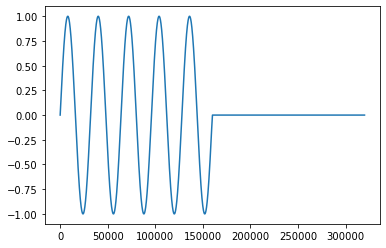

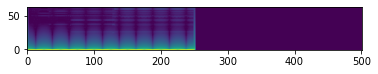

In [32]:
plt.plot(waveform)
plt.show()
plt.plot(waveform_stretch)
plt.show()
plt.imshow(spec_stretch_1, origin="lower")
plt.show()

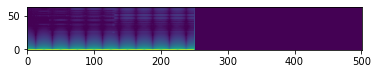

In [33]:
plt.imshow(spec_stretch_2, origin="lower")
plt.show()

In [34]:
diff = (spec_stretch_1 - spec_stretch_2).abs() + spec_stretch_1.min()


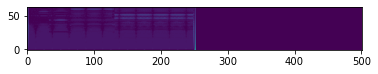

In [35]:
plt.imshow(diff, origin="lower")
plt.show()

ResamplePadCrop linear interpolation

In [36]:
from sslh.transforms.waveform.resample import Resample

# 0.5 Hz, 10 s
waveform2 = gen_note(20, 1, sr)

stretch_nearest = Resample(rates=(0.5, 0.5), interpolation='nearest')
stretch_linear = Resample(rates=(0.5, 0.5), interpolation='linear')

waveform2_stretch_nearest = stretch_nearest(waveform2)
waveform2_stretch_linear = stretch_linear(waveform2)

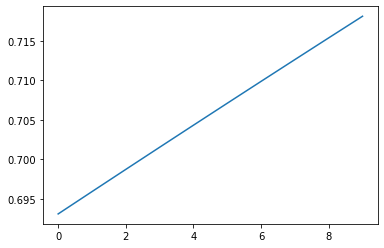

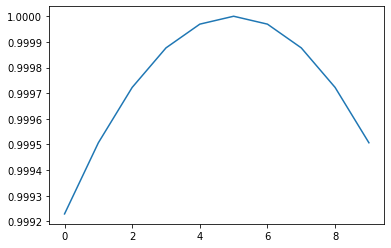

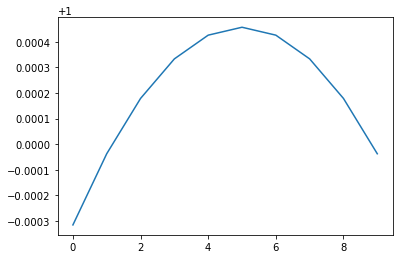

In [37]:
slices = slice(195, 205)

plt.plot(waveform2[slices])
plt.show()

plt.plot(waveform2_stretch_nearest[slices])
plt.show()

plt.plot(waveform2_stretch_linear[slices])
plt.show()

In [38]:
print(waveform2_stretch_nearest[slices].tolist())
print(waveform2_stretch_linear[slices].tolist())
print(waveform2_stretch_nearest.eq(waveform2_stretch_linear).all())

[0.9992290139198303, 0.9995065331459045, 0.999722421169281, 0.9998766183853149, 0.9999691843986511, 1.0, 0.9999691843986511, 0.9998766183853149, 0.999722421169281, 0.9995065331459045]
[0.9996848702430725, 0.9999628067016602, 1.000178575515747, 1.0003329515457153, 1.0004255771636963, 1.00045645236969, 1.0004255771636963, 1.0003329515457153, 1.000178575515747, 0.9999626278877258]
tensor(False)


CutOutSpec with different scales

In [39]:
cutoutspec_diff = CutOutSpec(freq_scales=(0.9, 1.0), time_scales=(0.0, 0.5))
spec_d = cutoutspec_diff(spec)

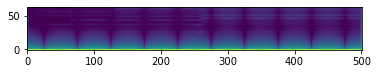

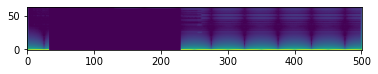

In [40]:
plt.imshow(spec, origin="lower")
plt.show()
plt.imshow(spec_d, origin="lower")
plt.show()

## Test flips

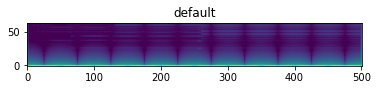

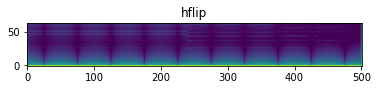

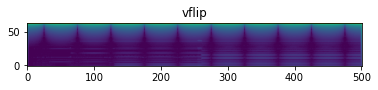

In [41]:
hflip = HorizontalFlip()
vflip = VerticalFlip()

plt.imshow(spec, origin="lower")
plt.title("default")
plt.show()
plt.imshow(hflip(spec), origin="lower")
plt.title("hflip")
plt.show()
plt.imshow(vflip(spec), origin="lower")
plt.title("vflip")
plt.show()

## Test SpecAugment

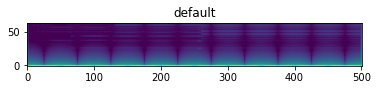

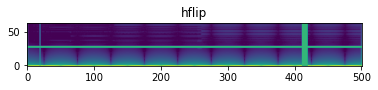

In [43]:
spec_aug = SpecAugmentation(16, 2, 2, 1, p=1.0, inplace=False)

plt.imshow(spec, origin="lower")
plt.title("default")
plt.show()
plt.imshow(spec_aug(spec.unsqueeze(dim=0)).squeeze(dim=0), origin="lower")
plt.title("hflip")
plt.show()